In [20]:
import os
import sys
import random
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv
from pickle import dump
from sklearn.model_selection import GroupShuffleSplit
from keras.utils.vis_utils import plot_model

clear_session()

In [21]:
def compute_metrics(pred,y_test):

    #print(pred)
    #print(y_test)
    diff = pred - y_test
    percentDiff = (diff / y_test) * 100
    
    #METRICS
    AbsPercentDiff = np.abs(percentDiff)
    MeanAPD = np.mean(AbsPercentDiff)
    StdAPD = np.std(AbsPercentDiff)
    
    CCTest  = pearsonr(y_test,pred)   #it should be the same thing of MATLAB 'corr' 
    RmseTest  = sqrt(mean_squared_error(y_test,pred))
    SITest  = sqrt(mean_squared_error(y_test,pred))/np.mean(y_test)
    BiasTest  = np.sum(pred-y_test)/y_test.shape[0]

    #print(CCTest[0],RmseTest,SITest,BiasTest,MeanAPD,StdAPD)
    return [CCTest[0],RmseTest,SITest,BiasTest,MeanAPD,StdAPD]

In [22]:
'''fixing seed'''
seed_value = 2

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
random_state = seed_value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [23]:

#WORKING DIRECTORY
path = Path.cwd()
save_path = Path(path / 'Ann_model_LSTM_real')
load_path = Path(path / 'Ann_model_LSTM')

parent_path =  path.parent

#DATA LOADING
data = pd.read_excel(parent_path / 'dataset\Real_Dataset2.xlsx', header=0)

print(data)
data.isnull().sum()
#variables to consider
feat = ['Influent Flow',
'Influent pH',
'Biofor DN Temperature',
'Biofor CN - Dissolved oxygen',
'Effluent Flow',
'Effluent pH']
 
targets = ['Effluent COD','Effluent Total suspended solids']

 
#data1 = data.loc[462:]
X = data[feat]
y = data[targets]
data.isnull().sum()
print(X)
Test=data

                    Date  Influent Flow  Influent pH     TMEDIA   
0    2021-12-23 10:00:00    2544.914865     6.892293  17.001293  \
1    2021-12-23 11:00:00    2562.337067     6.896180  16.770126   
2    2021-12-23 12:00:00    2608.118364     6.906006  16.768217   
3    2021-12-23 13:00:00    2492.566272     6.919798  16.840346   
4    2021-12-23 14:00:00    2406.911901     6.937250  16.354207   
...                  ...            ...          ...        ...   
2334 2022-03-31 05:00:00    2382.340405     8.168114  17.616545   
2335 2022-03-31 06:00:00    2426.835215     8.163622  17.716646   
2336 2022-03-31 07:00:00    2353.709824     8.149370  17.644735   
2337 2022-03-31 08:00:00    2413.925518     8.145649  18.062907   
2338 2022-03-31 09:00:00    2420.341770     8.103961  18.222254   

      Biofor CN - Dissolved oxygen  Effluent Flow  Effluent pH  NNOx_OUT_P   
0                         8.557711    2544.914865     6.820682    8.297333  \
1                         8.508642    2

In [24]:
n = len(data)
train = data[0:int(n*0.7)]
val = data[int(n*0.7):int(n*0.8)]
test = data[int(n*0.8):]

sel = feat+targets
train_df = train[sel]
val_df = val[sel]
test_df = test[sel]
Total=data[sel]

train_mean = train_df.mean()
print(train_mean[6:8])
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
Total_df=(Total- train_mean) / train_std

num_features = train_df.shape[1]


Effluent COD                       13.273481
Effluent Total suspended solids     6.151834
dtype: float64


In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}                                        

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [26]:
OUT_STEPS = 24
wide_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=6,
    label_columns=targets)

print(wide_window)

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['Effluent COD', 'Effluent Total suspended solids']


In [27]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

In [28]:
WindowGenerator.split_window = split_window

example_window=tf.stack([np.array(test_df[0:0+wide_window.total_window_size]),
                         np.array(test_df[200:200+wide_window.total_window_size]),
                         np.array(test_df[400:400+wide_window.total_window_size])])

example_inputs, example_labels = wide_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

wide_window.example = example_inputs, example_labels


All shapes are: (batch, time, features)
Window shape: (3, 30, 8)
Inputs shape: (3, 24, 8)
Labels shape: (3, 24, 2)


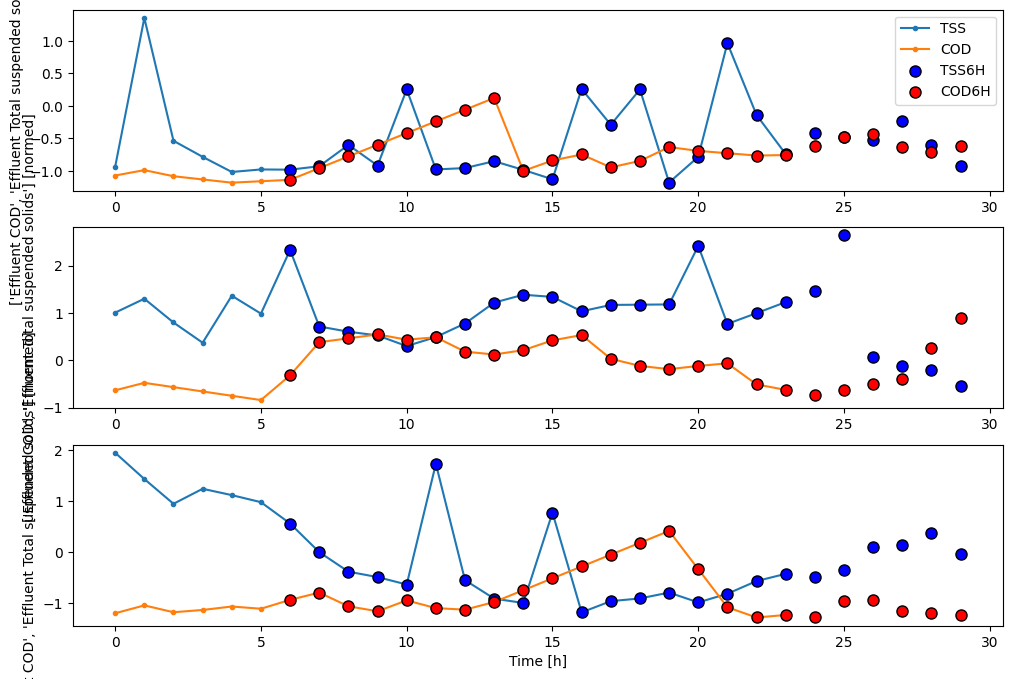

In [29]:
def plot(self, model=None, plot_col=targets[0:3], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  #print(plot_col)
  plot_col_index0 = self.column_indices[plot_col[0]]
  plot_col_index1 = self.column_indices[plot_col[1]]
  #plot_col_index2 = self.column_indices[plot_col[2]]
  #print(plot_col_index0, plot_col_index1, plot_col_index2)
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index0],
             label='TSS', marker='.', zorder=-10)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index1],
             label='COD', marker='.', zorder=-10)
    # plt.plot(self.input_indices, inputs[n, :, plot_col_index2],
    #          label='Inputs', marker='.', zorder=-10)
    
    if self.label_columns:
      label_col_index0 = self.label_columns_indices.get(plot_col[0], None)
      label_col_index1 = self.label_columns_indices.get(plot_col[1], None)
      #label_col_index2 = self.label_columns_indices.get(plot_col[2], None)
    else:
      label_col_index0 = plot_col_index0
      label_col_index1 = plot_col_index1
     # label_col_index2 = plot_col_index2

    if label_col_index0 is None and label_col_index1 is None and label_col_index2 is None:
      continue


    plt.scatter(self.label_indices, labels[n, :, label_col_index0],
                edgecolors='k', label='TSS6H', c='#0000FF', s=64)
    plt.scatter(self.label_indices, labels[n, :, label_col_index1],
                edgecolors='k', label='COD6H', c='#FF0000', s=64)
    # plt.scatter(self.label_indices, labels[n, :, label_col_index2],
    #             edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index0],
                  marker='X', edgecolors='k', label='TSS_pred', c='#0000FF', s=64)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index1],
                  marker='X', edgecolors='k', label='COD_pred', c='#FF0000', s=64)
      # plt.scatter(self.label_indices, predictions[n, :, label_col_index2],
      #             marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
wide_window.plot()


In [30]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)
  
  return ds

WindowGenerator.make_dataset = make_dataset

In [31]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example_window

wide_window.train.element_spec

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 8)
Labels shape (batch, time, features): (32, 24, 2)


In [32]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  model.save(save_path)
  return history


In [33]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS,3])
])


In [34]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dense(48,activation='relu'),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(48,activation='relu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*2,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 2])
])

In [35]:
history = compile_and_fit(multi_lstm_model, wide_window)

Epoch 1/100
51/51 [==============================] - 3s 31ms/step - loss: 0.7786 - mean_absolute_error: 0.6826 - val_loss: 0.5142 - val_mean_absolute_error: 0.5012
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 0.5722 - mean_absolute_error: 0.5712 - val_loss: 0.4581 - val_mean_absolute_error: 0.4620
Epoch 3/100
51/51 [==============================] - 1s 25ms/step - loss: 0.5515 - mean_absolute_error: 0.5580 - val_loss: 0.4480 - val_mean_absolute_error: 0.4315
Epoch 4/100
51/51 [==============================] - 1s 27ms/step - loss: 0.5425 - mean_absolute_error: 0.5529 - val_loss: 0.4688 - val_mean_absolute_error: 0.4725
Epoch 5/100
51/51 [==============================] - 1s 27ms/step - loss: 0.5136 - mean_absolute_error: 0.5345 - val_loss: 0.4443 - val_mean_absolute_error: 0.4472
Epoch 6/100
51/51 [==============================] - 1s 26ms/step - loss: 0.4684 - mean_absolute_error: 0.5031 - val_loss: 0.4349 - val_mean_absolute_error: 0.4571
Epoch 7/100
51/5

INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_LSTM_real\assets


INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_LSTM_real\assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


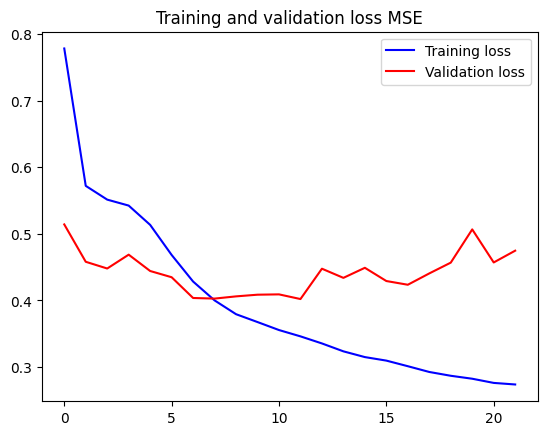

In [36]:
#PLOT TRAINING CURVES
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss MSE')
plt.legend()
plot_model(multi_lstm_model, show_shapes=True, show_layer_names=True)


7/7 [==============================] - 0s 11ms/step - loss: 0.4748 - mean_absolute_error: 0.4524


array([[[-0.39814758, -0.5680311 ],
        [-0.33407438, -0.70409745],
        [-0.42874914, -0.754845  ],
        ...,
        [-0.66256434, -1.0477393 ],
        [-0.657399  , -1.0682182 ],
        [-0.6530511 , -1.0560486 ]],

       [[ 0.92442983, -0.99457604],
        [ 0.9896081 , -1.3135394 ],
        [ 0.83929545, -1.4586469 ],
        ...,
        [ 0.310681  ,  0.9797146 ],
        [ 0.20244977,  0.84061587],
        [ 0.1470801 ,  0.67624503]],

       [[ 0.43105695, -0.38468045],
        [ 0.55189925, -0.50486577],
        [ 0.60406816, -0.66454405],
        ...,
        [-0.30782375, -1.0635736 ],
        [-0.22667104, -1.076842  ],
        [-0.21233234, -1.0184654 ]],

       ...,

       [[ 0.7308822 , -0.8838168 ],
        [ 0.827299  , -0.95175016],
        [ 0.711672  , -0.9616239 ],
        ...,
        [ 1.0270689 ,  0.3667189 ],
        [ 1.0074145 ,  0.60550755],
        [ 0.8526578 ,  0.6148629 ]],

       [[-0.39458185, -0.8291733 ],
        [-0.32121223, -0.93

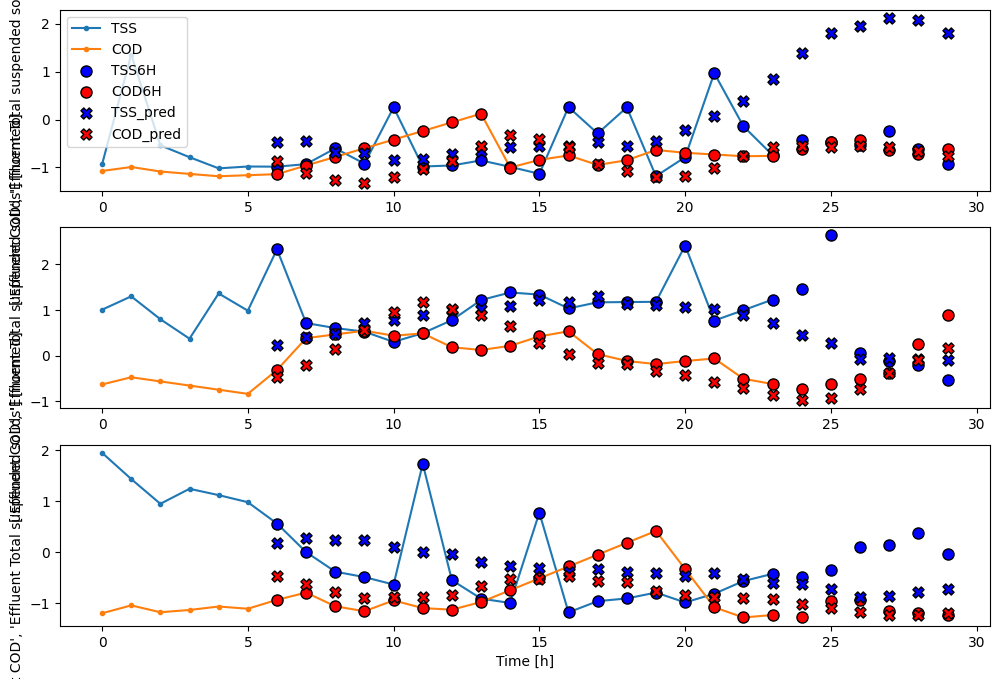

In [37]:
val_performance = multi_lstm_model.evaluate(wide_window.val)
performance = multi_lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_lstm_model)

predictions = multi_lstm_model.predict(wide_window.test, verbose=0)
predictions

[[ 1.8963165  2.0341     2.1803792  3.2832668  3.5001333  3.2877169
   3.2203834  4.0183496  3.07945    3.0796833  2.8984833  2.9073167
   2.75065    3.1894     3.3560834  2.9481833  2.704      5.3398094
   7.9756193 10.611428  10.546852  10.482275  10.417698  10.353121 ]
 [ 3.67645    3.5543168  3.5795     4.0430336  4.5502667  4.6699166
   4.018      3.7386665  4.034665   4.330663   4.6266613  4.9226594
   5.2186575  5.5146556  5.8106537  6.106652   6.40265    2.6193666
   2.77915    3.3172166  2.9020834  2.9494667  3.2444167  4.13665  ]
 [ 2.3279502  2.5567334  2.4090834  3.0002835  3.4779165  2.5709
   2.2423832  2.9611833  2.4503934  2.3472502  2.8531291  3.6379354
   4.422742   5.207548   5.9923544  6.7771606  7.5619674  5.034067
   2.506167   1.8296666  1.99645    1.8357668  2.9156165  3.0182002]
 [ 5.515683   5.47795    5.7942333  4.7245502  4.297633   3.4594166
   3.9952917  4.5311666  4.2224083  3.91365    3.6048918  3.2961333
   5.0711164  7.44475    7.7225585  8.000367   7.

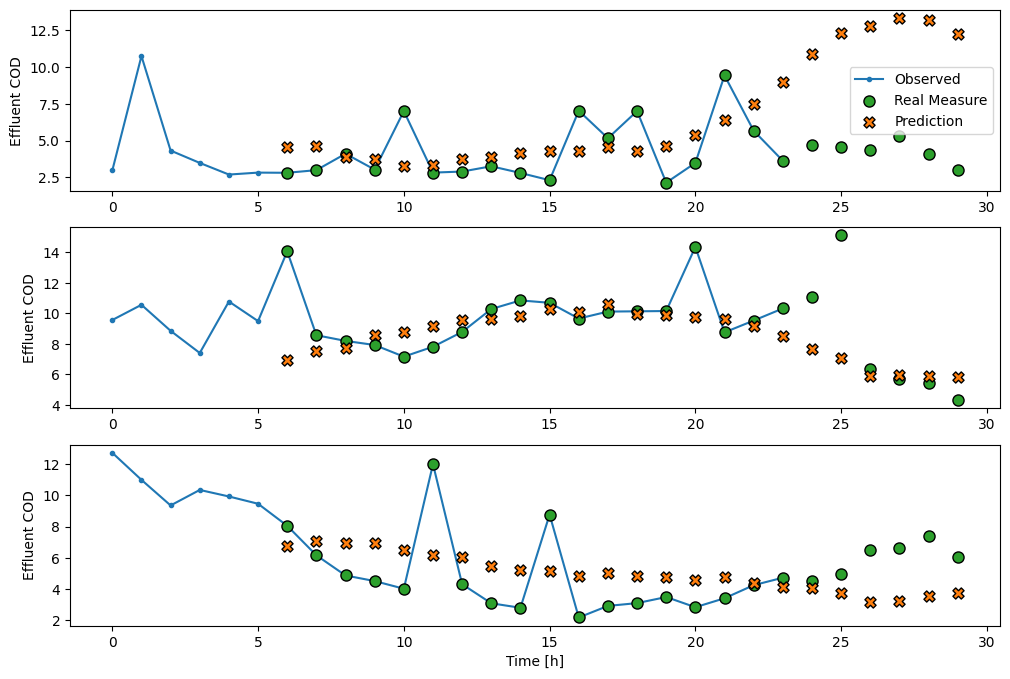

In [38]:
res = []
res_round = []

for inputs, labels in wide_window.test:
      labels = np.array(labels[:, :, -1])
      labels = labels*train_std['Effluent Total suspended solids']+train_mean['Effluent Total suspended solids']

      
      pred = multi_lstm_model(inputs)
      pred = np.array(pred[:, :, -1])
      pred = pred*train_std['Effluent Total suspended solids']+train_mean['Effluent Total suspended solids']

      for i in range(pred.shape[0]):
          res.append(compute_metrics(pred[i,:],labels[i,:].reshape(-1)))
          #res_round.append(compute_metrics(pred[i,:].round(),labels[i,:].reshape(-1).round()))

mean_res = np.mean(res, axis=0)
print(labels)
#mean_res_round = np.mean(res_round, axis=0)

print('----------------------------------------------------------------------')
print(mean_res)

wind_res = []
def plot_notscal(self, mean, std, wind_res, model=None, plot_col=targets[0], max_subplots=3):
  inputs, labels = self.example
  inputs_notscal = inputs*std+mean
  labels = labels*std+mean
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs_notscal[n, :, plot_col_index],
             label='Observed', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Real Measure', c='#2ca02c', s=64)
    if model is not None:
      preds = model(inputs)
      preds = preds*std+mean
      plt.scatter(self.label_indices, preds[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Prediction',
                  c='#ff7f0e', s=64)
      
      preds = np.array(preds[:, :, -1])

    #for i in range(preds.shape[0]):
     #     wind_res.append(compute_metrics(np.array(preds[i,:]),np.array(labels[i,:]).reshape(-1)))
    
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_notscal = plot_notscal        
wide_window.plot_notscal(train_mean['Effluent Total suspended solids'],train_std['Effluent Total suspended solids'], wind_res, multi_lstm_model)

[[11.045     10.5       10.9800005 11.68      12.080001  11.900001
  12.3       13.540001  13.68      14.320001  13.190001  13.530001
  12.095     11.05      10.75      10.89      11.440001  11.2300005
  14.475     13.290001  12.900001   9.300001   9.31       9.710001 ]
 [20.37      17.945     16.560001  16.470001  16.23      16.77
  16.75      16.18      15.610001  15.290001  16.12      16.95
  15.530001  14.320001  17.130001  16.060001  19.87      15.290001
  14.9800005 14.755     14.120001  14.660001  15.47      16.720001 ]
 [11.89      12.240001  11.530001  11.400001  10.280001  12.335
  14.400001  10.400001  10.42      10.960001   9.66       8.360001
   9.         9.950001  10.1       10.09      10.09      11.97
  10.01      11.2300005 11.620001  13.190001  17.57      14.205001 ]
 [11.490001  18.16      11.7300005 10.710001  10.47      15.460001
   9.950001  10.570001  10.72      11.045     10.5       10.9800005
  11.68      12.080001  11.900001  12.3       13.540001  13.68
  14.3

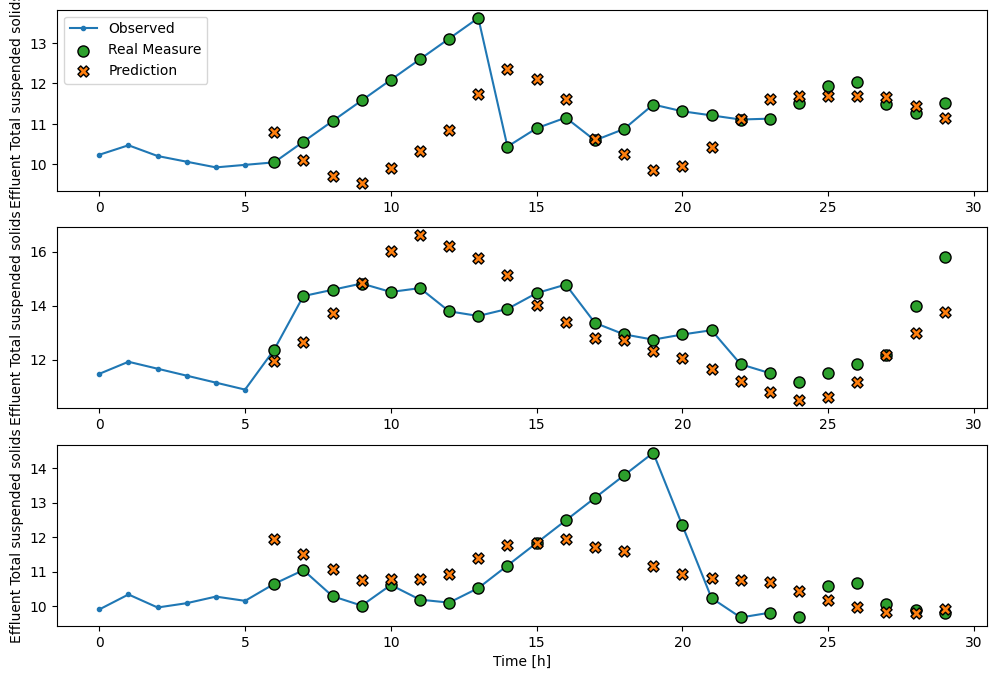

In [39]:
res = []
res_round = []

for inputs, labels in wide_window.test:
      labels = np.array(labels[:, :, -2])
      labels = labels*train_std['Effluent COD']+train_mean['Effluent COD']

      
      pred = multi_lstm_model(inputs)
      pred = np.array(pred[:, :, -2])
      pred = pred*train_std['Effluent COD']+train_mean['Effluent COD']

      for i in range(pred.shape[0]):
          res.append(compute_metrics(pred[i,:],labels[i,:].reshape(-1)))
          #res_round.append(compute_metrics(pred[i,:].round(),labels[i,:].reshape(-1).round()))

mean_res = np.mean(res, axis=0)
print(labels)
#mean_res_round = np.mean(res_round, axis=0)

print('----------------------------------------------------------------------')
print(mean_res)

wind_res = []
def plot_notscal(self, mean, std, wind_res, model=None, plot_col=targets[1], max_subplots=3):
  inputs, labels = self.example
  inputs_notscal = inputs*std+mean
  labels = labels*std+mean
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs_notscal[n, :, plot_col_index],
             label='Observed', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Real Measure', c='#2ca02c', s=64)
    if model is not None:
      preds = model(inputs)
      preds = preds*std+mean
      plt.scatter(self.label_indices, preds[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Prediction',
                  c='#ff7f0e', s=64)
      
      preds = np.array(preds[:, :, -2])

    #for i in range(preds.shape[0]):
     #     wind_res.append(compute_metrics(np.array(preds[i,:]),np.array(labels[i,:]).reshape(-1)))
    
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_notscal = plot_notscal
wide_window.plot_notscal(train_mean['Effluent COD'],train_std['Effluent COD'], wind_res, multi_lstm_model)

In [40]:
result_COD=[]
result_TSS=[]

input=tf.stack([np.array(Total_df[0:24][:])])
pred=multi_lstm_model(input)

for i in range(24):
  b=(pred[0][i][1]).numpy()*train_std['Effluent COD']+train_mean['Effluent COD']
  c=(pred[0][i][0]).numpy()*train_std['Effluent Total suspended solids']+train_mean['Effluent Total suspended solids']
  result_COD.append(b)
  result_TSS.append(c)
for j in range(24,2339):
  input=tf.stack([np.array(Total_df[j-24+1:j+1][:])])
  pred=multi_lstm_model(input)
  b=(pred[0][23][1]).numpy()*train_std['Effluent COD']+train_mean['Effluent COD']
  c=(pred[0][23][0]).numpy()*train_std['Effluent Total suspended solids']+train_mean['Effluent Total suspended solids']
  result_COD.append(b)
  result_TSS.append(c)

Test['Effluent COD ANN 6H']=result_COD
Test['Effluent TSS ANN 6H']=result_TSS

print(Test)
with pd.ExcelWriter(save_path / 'output6H_REALE_2.xlsx') as writer:  
    Test.to_excel(writer, sheet_name='Sheet_name_1')

                    Date  Influent Flow  Influent pH     TMEDIA   
0    2021-12-23 10:00:00    2544.914865     6.892293  17.001293  \
1    2021-12-23 11:00:00    2562.337067     6.896180  16.770126   
2    2021-12-23 12:00:00    2608.118364     6.906006  16.768217   
3    2021-12-23 13:00:00    2492.566272     6.919798  16.840346   
4    2021-12-23 14:00:00    2406.911901     6.937250  16.354207   
...                  ...            ...          ...        ...   
2334 2022-03-31 05:00:00    2382.340405     8.168114  17.616545   
2335 2022-03-31 06:00:00    2426.835215     8.163622  17.716646   
2336 2022-03-31 07:00:00    2353.709824     8.149370  17.644735   
2337 2022-03-31 08:00:00    2413.925518     8.145649  18.062907   
2338 2022-03-31 09:00:00    2420.341770     8.103961  18.222254   

      Biofor CN - Dissolved oxygen  Effluent Flow  Effluent pH  NNOx_OUT_P   
0                         8.557711    2544.914865     6.820682    8.297333  \
1                         8.508642    2